In [6]:
import pandas as pd
import numpy as np
from surprise import SVDpp
from surprise import Dataset
from surprise.model_selection import train_test_split
from surprise import accuracy
from surprise import Reader
from collections import OrderedDict
import matplotlib.pyplot as plt
plt.rcParams.update({'figure.max_open_warning': 0})
import seaborn as sns
sns.set_style('whitegrid')

In [7]:
ratings_df = pd.read_csv('H:\\255\\ml-latest-small\\ratings.csv')
movies_df = pd.read_csv('H:\\255\\ml-latest-small\\movies.csv')

In [8]:
min_ratings = 10
filter_items = ratings_df['movieId'].value_counts() > min_ratings
filter_items = filter_items[filter_items].index.tolist()

min_user_ratings = 10
filter_users = ratings_df['userId'].value_counts() > min_user_ratings
filter_users = filter_users[filter_users].index.tolist()

df_new = ratings_df[(ratings_df['movieId'].isin(filter_items)) & (ratings_df['userId'].isin(filter_users))]
print('The original data frame shape:\t{}'.format(ratings_df.shape))
print('The new data frame shape:\t{}'.format(df_new.shape))

The original data frame shape:	(100836, 4)
The new data frame shape:	(79636, 4)


In [9]:
def SVDppCF(ratings):
    reader = Reader(rating_scale=(0,5))
    data = Dataset.load_from_df(ratings,reader)
    svd = SVDpp()
    trainset, testset = train_test_split(data, test_size=0.25)
    predictions = svd.fit(trainset).test(testset)
    acc = accuracy.rmse(predictions)
    return acc,predictions

In [12]:
svdpp_model,predictions = SVDppCF(df_new[['userId','movieId','rating']])

RMSE: 0.8409


In [13]:
user_counts = df_new.groupby('userId').size()

[(0.0, 300.0),
 (0.0, 500.0),
 Text(0.5, 1.0, 'Distribution of User Ratings'),
 Text(0.5, 0, 'Number of Ratings')]

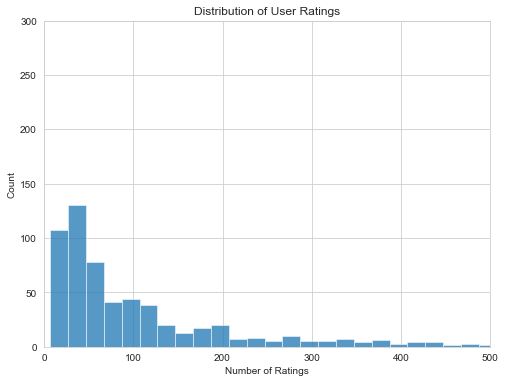

In [11]:
fig, ax = plt.subplots(figsize=(8, 6))
sns.set_style('whitegrid')

sns.histplot(user_counts, binwidth=20, ax=ax)
ax.set(ylim=[0,300], xlim=[0,500], title='Distribution of User Ratings', xlabel='Number of Ratings')

In [14]:
# classify user base on counts of rating
active_levels = ['<20', '20-50', '50-80', '80-150', '>150']

user_counts_levels = dict.fromkeys(active_levels, None)
user_counts_levels['<20'] = user_counts[(user_counts < 20)]
user_counts_levels['20-50'] = user_counts[(user_counts >= 20) & (user_counts < 50)]
user_counts_levels['50-80'] = user_counts[(user_counts >= 50) & (user_counts < 80)]
user_counts_levels['80-150'] = user_counts[(user_counts >= 80) & (user_counts < 150)]
user_counts_levels['>150'] = user_counts[user_counts >= 150]

In [16]:
user_level_rmse = []
for key in active_levels:
    indices = user_counts_levels[key].index.tolist()
    pred_df = df_new[df_new['userId'].isin(indices)]
    print(len(pred_df))
    #y_true = pred_df['rating']
    y_rmse,r_pred = SVDppCF(pred_df[['userId','movieId','rating']])
    user_level_rmse.append(y_rmse)

322
RMSE: 1.2240
6962
RMSE: 0.9350
6217
RMSE: 0.9216
12384
RMSE: 0.9437
53751
RMSE: 0.8175


[[Text(0, 0, '<20'),
  Text(1, 0, '20-50'),
  Text(2, 0, '50-80'),
  Text(3, 0, '80-150'),
  Text(4, 0, '>150')],
 Text(0.5, 0, 'Number of ratings'),
 Text(0, 0.5, 'rmse')]

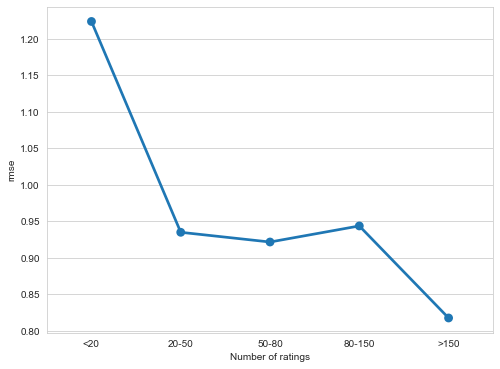

In [17]:
fig, ax = plt.subplots(figsize=(8, 6))
sns.set_style('whitegrid')

sns.pointplot(y=user_level_rmse, x=np.arange(5))
ax.set(xticklabels=active_levels, xlabel='Number of ratings', ylabel='rmse')

In [18]:
#display(predictions)
users = []
movies = []
r_ui = []
est = []
predictions_df = pd.DataFrame()
for prediction in predictions:
    if prediction[4]['was_impossible'] == False:
        users.append(prediction[0])
        movies.append(prediction[1])
        r_ui.append(prediction[2])
        est.append(prediction[3])
predictions_df['userId'] = users 
predictions_df['movieId'] = movies
predictions_df['r_ui'] = r_ui
predictions_df['est'] = est
display(predictions_df.head())
predictions_df.to_csv("svdpp_predictions.csv",index=False)
        



,userId,movieId,r_ui,est
0,93,2193,5.0,4.094483
1,266,1200,5.0,4.275680
2,338,2959,4.5,4.056992
3,507,47,3.0,3.883538
4,567,103141,2.5,2.646509
